In [2]:
import pyklip.parallelized as par
import pyklip.klip as klip
import glob
import pyklip.instruments.GPI as gpi
import gpiklip_fm as fm
import pyfits
import matplotlib.pyplot as plot
import matplotlib
import numpy
from hr4796a import OffsetRingModel
from hr4796a import KLIPPolModelComparator

from hr4796a import ModelComparator
import pickle
from scipy.interpolate import splrep, splev
import pyfits

In [3]:
kpolmc = pickle.load(open('../dat_files/hr4796-fitter-kpol-mcmc.dat'))
jpolmc = pickle.load(open('../dat_files/hr4796-fitter-jpol-mcmc.dat'))
jintmc = pickle.load(open('../dat_files/hr4796-fitter-Jintonly-mcmc.dat'))
kintmc = pickle.load(open('../dat_files/hr4796-fitter-kint-mcmc.dat'))

In [4]:
pixelscale = .014            # arcseconds / pix
dist = 73.                   # parsecs,cn
pix_au = dist * pixelscale   # AU / pix
ylims = 70. * pix_au
xlims = 90. * .7 * pix_au
cenx = 140
ceny = 140
extent = numpy.array([-ceny,ceny,-cenx,cenx]) * pix_au
calibk = 5.7e-8             # Jy/ADU/coadd
calibk_as = calibk * 1000. / pixelscale**2.  # Jy/ADU/coadd/as^2
calibj = 1.03e-7 * .73
calibj_as = calibj * 1000. / pixelscale**2.

colormap_idl_bluewhite = matplotlib.colors.LinearSegmentedColormap('IDL_BlueWhite',
        {'red':   ((0.0, 0.0, 0.0),
                   (0.756, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),


         'green': ((0.0, 0.0, 0.0),
                   (0.38, 0.0, 0.0),
                   (1.00, 1.0, 1.0)),

         'blue':  ((0.00, 0.0, 0.0),
                   (0.737, 1.0, 1.0),
                   (1.00, 1.0, 1.0))
        })
colormap_idl_bluewhite.set_bad('black')

<h2>Total Intensity</h2>

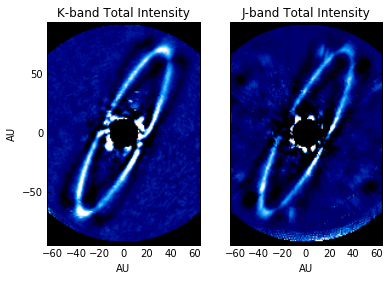

In [5]:
kim = pyfits.getdata('../files_for_fit/S20140422K-forfm-KLmodes-KL2-masked.fits')
jim = pyfits.getdata('../files_for_fit/S20140422J-forfm-KLmodes-KL2-masked.fits')


plot_kwargs =  {'extent': extent,
                'cmap': colormap_idl_bluewhite,}
    
fig,(ax1,ax2) = plot.subplots(1,2,sharex = True, sharey = True)
im = ax1.imshow(kim, vmin=-75, vmax = 120, **plot_kwargs)
ax1.set_ylim(-ylims, ylims)
ax1.set_xlim(-xlims, xlims)
ax1.set_xlabel('AU')
ax1.set_ylabel('AU')
ax1.set_title('K-band Total Intensity')
ax2.imshow(jim, vmin=-100, vmax = 200, **plot_kwargs)
ax2.set_title('J-band Total Intensity')
ax2.set_xlabel('AU')
ax2.set_xlim(-xlims, xlims)

plot.show()

<h2>Total Intensity Raw and Subtracted</h2>

In [6]:
raw = pyfits.getdata('april_k/rawsum.fits') * calibk_as
reduced = pyfits.getdata('S20140422K-KLmodes-KL1.fits') * calibk_as
plot_kwargs =  {'extent': extent,
                'cmap': colormap_idl_bluewhite,
                'vmin': -100 * calibk_as,
                'vmax': 200 * calibk_as}

fig,(ax1,ax2) = plot.subplots(1,2,sharex = True, sharey = True)
im = ax1.imshow(raw, **plot_kwargs)
ax1.set_ylim(-ylims, ylims)
ax1.set_xlim(-xlims, xlims)
ax1.set_xlabel('AU')
ax1.set_ylabel('AU')
ax1.set_title('Unsubtracted K Total Intensity')
ax2.imshow(reduced, **plot_kwargs)
ax2.set_title('KLIP subtracted K Total Intensity')
ax2.set_xlabel('AU')
ax2.set_xlim(-xlims, xlims)

ax2.set_ylim(-ylims, ylims)
fig.subplots_adjust(bottom = .23)
cbar_ax = fig.add_axes([0.15,0.12,0.7,0.03])
cb = fig.colorbar(im, cax = cbar_ax, orientation = 'horizontal', label = 'mJy / arcsec$^2$')
plot.savefig('totcomp.png')
plot.show()

IOError: [Errno 2] No such file or directory: 'april_k/rawsum.fits'

<h2>Polarization Image</h2>

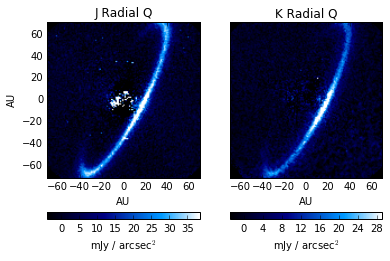

In [14]:
jpolim = pyfits.getdata('../files_for_fit/HR4796A-J-Qr-masked.fits') * calibj_as 
kpolim = pyfits.getdata('../files_for_fit/HR4796A-K1-Qr-masked.fits') * calibk_as 
plot_kwargs =  {'extent': extent,
                'cmap': colormap_idl_bluewhite}
fig,(ax1, ax2) = plot.subplots(1, 2, sharex = True, sharey = True)
jim = ax1.imshow(jpolim, vmin = -10 * calibj_as, vmax = 100. * calibj_as, **plot_kwargs)
ax1.set_ylim(-ylims, ylims)
ax1.set_xlim(-xlims, xlims)
ax1.set_xlabel('AU')
ax1.set_title('J Radial Q')
ax1.set_ylabel('AU')
cb = plot.colorbar(jim, ax = ax1, orientation = 'horizontal', label='mJy / arcsec$^2$')


kim = ax2.imshow(kpolim, vmin = -10 * calibk_as, vmax = 100. * calibk_as, **plot_kwargs)
ax2.set_xlim(-xlims, xlims)
ax2.set_ylim(-ylims, ylims)
ax2.set_title('K Radial Q')
cb2 = plot.colorbar(kim, ax = ax2, orientation = 'horizontal', label='mJy / arcsec$^2$')

ax2.set_xlabel('AU')

#fig.subplots_adjust(bottom = .23)
#cbar_ax = fig.add_axes([0.15,0.12,0.7,0.03])
plot.savefig('polint.png')
plot.show()

<h2>Polarization Residuals</h2>

In [7]:
kstdim = numpy.array(kpolmc.stdims)[0] * calibk_as
jstdim = numpy.array(jpolmc.stdims)[0] * calibj_as
jmodel = pyfits.getdata('../output_fits/pol_j_model.fits') * calibj_as
kmodel = pyfits.getdata('../output_fits/pol_k_model.fits') * calibk_as
jpolim = pyfits.getdata('../files_for_fit/HR4796A-J-Qr-masked.fits') * calibj_as
kpolim = pyfits.getdata('../files_for_fit/HR4796A-K1-Qr-masked.fits') * calibk_as

import matplotlib 
label_size = 10.5
matplotlib.rcParams['xtick.labelsize'] = label_size
matplotlib.rcParams['ytick.labelsize'] = label_size
fig,(ax1, ax2, ax3) = plot.subplots(1, 3)
fig.set_size_inches(9,4.5)
plot_kwargs =  {'extent': extent,
                'cmap': colormap_idl_bluewhite,
                'vmin': -10* calibk_as,
                'vmax': 100. * calibk_as}
fig.suptitle('K-band Polarized Intensity',fontsize = 15)
im = ax1.imshow(kpolim, **plot_kwargs)
ax1.set_xlim([-xlims, xlims])
ax1.set_ylim([-90, 90])
ax1.set_title('Data')
ax2.imshow(kmodel, **plot_kwargs)
ax2.set_ylim([-90, 90])
ax2.set_xlim([-xlims, xlims])
ax2.set_title('Model')
ax3.imshow(kpolim - kmodel, **plot_kwargs)
ax3.set_ylim([-90, 90])
ax3.set_xlim([-xlims, xlims])
ax3.set_title('Residuals')
fig.subplots_adjust(wspace = .2)

fig.subplots_adjust(bottom = .23)

cbar_ax = fig.add_axes([0.15,0.12,0.7,0.03])
cb = fig.colorbar(im, cax = cbar_ax, orientation = 'horizontal', label = 'mJy / arcsec$^2$')
fig.savefig('kpolfit.png')
#plot.show()

plot.clf()
fig,(ax1, ax2, ax3) = plot.subplots(1, 3)
fig.set_size_inches(9,4.5)
plot_kwargs =  {'extent': extent,
                'cmap': colormap_idl_bluewhite,
                'vmin': -10* calibj_as,
                'vmax': 100. * calibj_as}
fig.suptitle('J-band Polarized Intensity',fontsize = 15)
im = ax1.imshow(jpolim, **plot_kwargs)
ax1.set_xlim([-xlims, xlims])
ax1.set_ylim([-90, 90])
ax1.set_title('Data')
ax2.imshow(jmodel, **plot_kwargs)
ax2.set_ylim([-90, 90])
ax2.set_xlim([-xlims, xlims])
ax2.set_title('Model')
ax3.imshow(jpolim - jmodel, **plot_kwargs)
ax3.set_ylim([-90, 90])
ax3.set_xlim([-xlims, xlims])
ax3.set_title('Residuals')
fig.subplots_adjust(wspace = .2)

fig.subplots_adjust(bottom = .23)

cbar_ax = fig.add_axes([0.15,0.12,0.7,0.03])
cb = fig.colorbar(im, cax = cbar_ax, orientation = 'horizontal', label = 'mJy / arcsec$^2$')
fig.savefig('jpolfit.png')
#plot.show()


plot.clf()



<h2>Total Intensity Fit</h2>

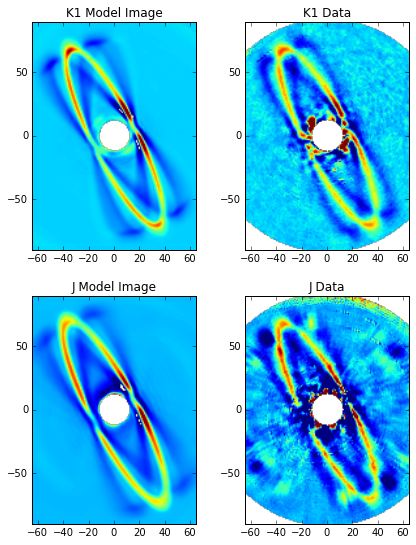

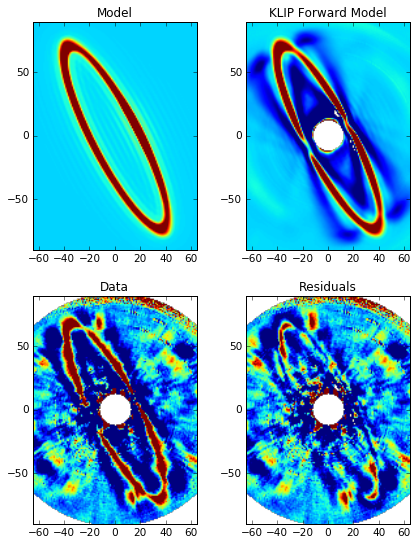

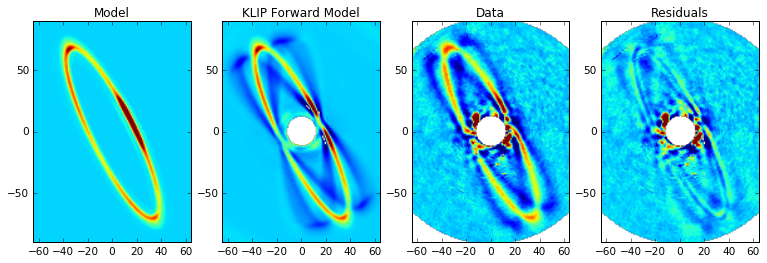

In [4]:
jmod = pyfits.getdata('../output_fits/tot_j_model.fits') * calibj_as
jmod_klip = pyfits.getdata('../output_fits/tot_j_model_klip.fits') * calibj_as
kmod = pyfits.getdata('../output_fits/tot_k_model.fits') * calibj_as
kmod_klip = pyfits.getdata('../output_fits/tot_k_model_klip.fits') * calibj_as
kim = pyfits.getdata('../files_for_fit/S20140422K-forfm-KLmodes-KL2-masked.fits') * calibj_as
jim = pyfits.getdata('../files_for_fit/S20140422J-forfm-KLmodes-KL2-masked.fits') * calibj_as


fig, ((ax1, ax2), (ax3, ax4)) = plot.subplots(2, 2)
fig.set_size_inches(7,9)
ax1.imshow(kmod_klip, extent = extent, vmin = -40, vmax = 80, origin = 'lower')
ax1.set_title('K1 Model Image')
ax1.set_xlim([-xlims, xlims])
ax1.set_ylim([-90, 90])
ax2.imshow(kim, extent = extent, vmin = -40, vmax = 80, origin = 'lower')
ax2.set_title('K1 Data')
ax2.set_xlim([-xlims, xlims])
ax2.set_ylim([-90, 90])
ax3.imshow(jmod_klip, extent = extent, vmin = -40, vmax = 90, origin = 'lower')
ax3.set_title('J Model Image')
ax3.set_xlim([-xlims, xlims])
ax3.set_ylim([-90, 90])
ax4.imshow(jim, extent = extent, vmin = -40, vmax = 90,  origin = 'lower')
ax4.set_title('J Data')
ax4.set_xlim([-xlims, xlims])
ax4.set_ylim([-90, 90])
plot.show()



label_size = 10.5
matplotlib.rcParams['xtick.labelsize'] = label_size
matplotlib.rcParams['ytick.labelsize'] = label_size


plot_kwargs =  {'extent': extent,
                'vmin': -40* calibj_as,
                'vmax': 80. * calibj_as,
                'origin':'lower'}

fig, ((ax1,ax2),(ax3,ax4)) = plot.subplots(2,2)
fig.set_size_inches(7,9)
ax1.imshow(jmod, **plot_kwargs)
ax1.set_xlim([-xlims, xlims])
ax1.set_ylim([-90, 90])
ax1.set_title('Model')
ax2.imshow(jmod_klip, **plot_kwargs)
ax2.set_xlim([-xlims, xlims])
ax2.set_ylim([-90, 90])
ax2.set_title('KLIP Forward Model')
ax3.imshow(jim, **plot_kwargs)
ax3.set_xlim([-xlims, xlims])
ax3.set_ylim([-90, 90])
ax3.set_title('Data')
ax4.imshow(jim - jmod_klip, **plot_kwargs)
ax4.set_xlim([-xlims, xlims])
ax4.set_ylim([-90, 90])
ax4.set_title('Residuals')
fig.savefig('jintfit.png')
plot.show()




label_size = 10.5
matplotlib.rcParams['xtick.labelsize'] = label_size
matplotlib.rcParams['ytick.labelsize'] = label_size


plot_kwargs =  {'extent': extent,
                'vmin': -100* calibj_as,
                'vmax': 200. * calibj_as,
                'origin': 'lower'}


fig, (ax1,ax2,ax3,ax4) = plot.subplots(1,4)
fig.set_size_inches(13,5)
ax1.imshow(kmod, **plot_kwargs)
ax1.set_xlim([-xlims, xlims])
ax1.set_ylim([-90, 90])
ax1.set_title('Model')
ax2.imshow(kmod_klip, **plot_kwargs)
ax2.set_xlim([-xlims, xlims])
ax2.set_ylim([-90, 90])
ax2.set_title('KLIP Forward Model')
ax3.imshow(kim, **plot_kwargs)
ax3.set_xlim([-xlims, xlims])
ax3.set_ylim([-90, 90])
ax3.set_title('Data')
ax4.imshow(kim - kmod_klip, **plot_kwargs)
ax4.set_xlim([-xlims, xlims])
ax4.set_ylim([-90, 90])
ax4.set_title('Residuals')
fig.savefig('kintfit.png')
plot.show()

<h2>Polarization Phase Curve</h2>

In [66]:
from scipy.interpolate import splev
eval_pspl = lambda phi, tck: splev(phi % (2.*numpy.pi), tck)

def get_tck(params, k=3):
    "get periodic spline parameters"
    n_param = len(params)

    x_min, x_max = 0., 2.*numpy.pi
    dt = (x_max-x_min)/n_param

    n_knot = n_param + 2*k + 1
    t = (numpy.arange(n_knot)-k)*dt

    c = numpy.zeros(n_knot, dtype=numpy.float)
    c[0:n_param] = params
    c[n_param:n_param+k] = params[0:k]

    return t, c, k


def get_NE_new(nu, mc):
    r = mc.ringmodel.parms['r']
    offset = mc.ringmodel.parms['offset']
    #offset *= 10 # TEMP                                                                
                                           
    I = -mc.ringmodel.parms['I']
    omega = mc.ringmodel.parms['omega']
    Omega = mc.ringmodel.parms['Omega']

    so, co = n.sin(omega), n.cos(omega)
    sO, cO = n.sin(Omega), n.cos(Omega)
    si, ci = n.sin(I), n.cos(I)
    oN = offset * (cO*co-sO*so*ci) # [AU]                                             
    oE = offset * (sO*co+cO*so*ci) # [AU]                                             
    oz = offset * so*si # [AU]     
    sonu, conu = n.sin(omega+nu), n.cos(omega+nu)

    pN = r * (cO*conu-sO*sonu*ci) # [AU]                                          
    pE = r * (sO*conu+cO*sonu*ci) # [AU]                                          
    pz = r * sonu*si

    pN -= oN
    pE -= oE
    pz -= oz

    r_star = n.sqrt(pN**2 + pE**2 + pz**2)

     # scattering angle                                                            
    phi_sca = n.arccos(pz/r_star) # [rad]                                         

    return pN, pE, phi_sca



import numpy as n
def new_phisca_array(mc):
    r = mc.ringmodel.parms['r']
    offset = mc.ringmodel.parms['offset']
    #offset *= 10 # TEMP                                                              
    I = -mc.ringmodel.parms['I']
    omega = mc.ringmodel.parms['omega']
    Omega = mc.ringmodel.parms['Omega']

    so, co = n.sin(omega), n.cos(omega)
    sO, cO = n.sin(Omega), n.cos(Omega)
    si, ci = n.sin(I), n.cos(I)
    oN = offset * (cO*co-sO*so*ci) # [AU]                                             
    oE = offset * (sO*co+cO*so*ci) # [AU]                                             
    oz = offset * so*si # [AU]                                                        
    def get_NE(nu):
        sonu, conu = n.sin(omega+nu), n.cos(omega+nu)

        pN = r * (cO*conu-sO*sonu*ci) # [AU]                                          
        pE = r * (sO*conu+cO*sonu*ci) # [AU]                                          
        pz = r * sonu*si

        pN -= oN
        pE -= oE
        pz -= oz

        r_star = n.sqrt(pN**2 + pE**2 + pz**2)

        # scattering angle                                                            
        phi_sca = n.arccos(pz/r_star) # [rad]                                         

        return pN, pE, phi_sca
                              

    # calculate ellipse                                                               
    nu = n.linspace(0., 2.*n.pi, 30, endpoint=True)
    pN, pE, phi_sca = get_NE(nu)


    # nus for which theta_sca = min, max                                              
    from scipy.optimize import fmin, brentq
    
    nus = n.array([fmin(lambda nu: get_NE(nu)[2], 0.)[0], 
                    fmin(lambda nu: -get_NE(nu)[2], 0.)[0]]) % (2.*n.pi)
    nu_min = nus.min()
    nu_max = nus.max()                   

    phi_scas = n.arange(13., 160., 10.)
    nuret = []
    phiret = []
    for phi in phi_scas:
        def comp(nu):
            d = (get_NE(nu)[2]-phi*n.pi/180.) % (2.*n.pi)
            if d > n.pi: d -= 2.*n.pi
            return d
        # which nus does this correspond to?
        nu1 = brentq(comp, nu_min, nu_max) #% (2.*n.pi)
        nu2 = brentq(comp, nu_max, nu_min+2.*n.pi) #%# (2.*n.pi)
        nuret.append(nu1)
        nuret.append(nu2)
        phiret.append(phi)
        phiret.append(phi)
        
    return numpy.array(nuret), numpy.array(phiret)

kpolmc = pickle.load(open('../dat_files/hr4796-fitter-kpol-mcmc.dat'))
kpolmc.ringmodel.parms['omega'] = -22.3 * numpy.pi / 180.
kpolmc.ringmodel.parms['offset'] = 1.5

a = new_phisca_array(kpolmc)

Optimization terminated successfully.
         Current function value: 0.223288
         Iterations: 25
         Function evaluations: 50
Optimization terminated successfully.
         Current function value: -2.918304
         Iterations: 27
         Function evaluations: 54
min 111.246917897 167.206511638
max 293.350684481 12.7934883586


Optimization terminated successfully.
         Current function value: 0.223288
         Iterations: 25
         Function evaluations: 50
Optimization terminated successfully.
         Current function value: -2.918304
         Iterations: 27
         Function evaluations: 54
min 111.246917897 167.206511638
max 293.350684481 12.7934883586
[  13.   13.   23.   23.   33.   33.   43.   43.   53.   53.   63.   63.
   73.   73.   83.   83.   93.   93.  103.  103.  113.  113.  123.  123.
  133.  133.  143.  143.  153.  153.]
6.28318232007
1.17626055018
6.28318222401
0.498343964134
6.28318210708
0.182779103489
6.28318194176
0.0550529254089
6.28318165357
0.0138256486073
6.2831810325
0.00295097528876
6.2831793446
0.000447482629925
6.28317190138
6.28315089042
0.00014377431188
6.28317551155
5.74466086145e-07
6.28318529015
6.28318530715
4.16333634234e-16
6.28318530718


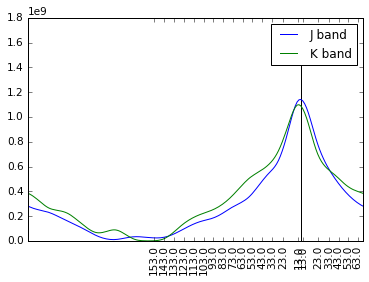

In [83]:
jpolmc = pickle.load(open('../dat_files/hr4796-fitter-Jintonly-mcmc.dat'))
kpolmc = pickle.load(open('../dat_files/hr4796-fitter-Kint-mcmc.dat'))
#kint = kpolmc.ringmodel.parms['int_parms']
#jint = jpolmc.ringmodel.parms['int_parms']


kpolmc = pickle.load(open('../dat_files/hr4796-fitter-kpol-mcmc.dat'))
jpolmc = pickle.load(open('../dat_files/hr4796-fitter-jpol-mcmc.dat'))
kint = kpolmc.ringmodel.parms['pol_int_parms']
jint = jpolmc.ringmodel.parms['pol_int_parms']


def test():
    nu = numpy.linspace(0,2. *numpy.pi, 360)

    pN, pE, kphi =get_NE(nu, kpolmc)
    wh = numpy.where(kphi == numpy.min(kphi))[0][0]

    kphi = numpy.append(kphi[wh:], kphi[:wh])
    knu = numpy.append(nu[wh:], nu[:wh])

    pN, pE,jphi = get_NE_new(nu, jpolmc)
    wh = numpy.where(jphi == numpy.min(jphi))[0][0]
    jphi = numpy.append(jphi[wh:], jphi[:wh])

    jnu = numpy.append(nu[wh:], nu[:wh])

    kpolint = eval_pspl(knu, get_tck(kint))
    jpolint = eval_pspl(jnu, get_tck(jint))

    plot.plot(kphi, kpolint, label = 'omega = fit, k')
    plot.plot(jphi,jpolint, label = 'omega = fit, j')


kpolmc.ringmodel.parms['omega'] = -22.3 * numpy.pi / 180.
jpolmc.ringmodel.parms['omega'] = -22.3 * numpy.pi / 180.
kpolmc.ringmodel.parms['offset'] = 1.5
jpolmc.ringmodel.parms['offset'] = 1.5
omega = -22.3 * numpy.pi / 180.

#knu, kphi = new_phisca_array(kpolmc)
#jnu, jphi = new_phisca_array(jpolmc)

nu = numpy.linspace(0., 2* numpy.pi, 180)
pN, pE,phi = get_NE_new(nu, kpolmc) 

kpolint = eval_pspl(nu + omega, get_tck(kint))
jpolint = eval_pspl(nu + omega, get_tck(jint))


plot.plot(nu * 180 / 3.14, kpolint, label = 'J band' )
plot.plot(nu * 180 / 3.14, jpolint, label = 'K band')
phis, nus = new_phisca_array(kpolmc)
print nus
plot.xticks(phis*180. /3.14,nus, rotation='vertical')
#minphi = 90. - kpolmc.ringmodel.parms['I'] * 180. / 3.14 + .1


minphi = .1
                                        
from scipy.optimize import fmin, brentq
def comp(nu):
    minphi = 90 - kpolmc.ringmodel.parms['I'] * 180. / numpy.pi  + .005
    d = (get_NE_new(nu, kpolmc)[2]-minphi*n.pi/180.) % (2.*n.pi)
    print d
    if d > n.pi: d -= 2.*n.pi
    return d
# which nus does this correspond to?
nu2 = brentq(comp, 293 * numpy.pi / 180., 372 * numpy.pi / 180)
#print nu2



plot.vlines(nu2 * 180. / numpy.pi, 0, numpy.max(kpolint) * 1.5)
plot.legend()
plot.show()
